# Leveraging the Word vec Result to clustering
### Classify industries according to BERT result

In [39]:
import pandas as pd
import numpy as np
from functools import reduce
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')

In [3]:
file=eval(open('company dic i.txt').read())
comp_corr=dict(file)

In [4]:
max_num=len(comp_corr)
comp_corr=[(key,[(subkey,subitem) for subkey,subitem in item.items()]) for key,item in comp_corr.items()]
comp_corr.sort(key=lambda x:x[0])
company_index=dict([(i,comp_corr[i][0]) for i in range(max_num)])
cov_matrix=[list(map(lambda x: x[1],sorted(comp_corr[0][1],key=lambda x: x[0])))]
for i in range(1,max_num):
    cov_matrix+=[list(map(lambda x: x[1],sorted(comp_corr[i][1],key=lambda x: x[0])))]
cov_matrix=np.matrix(cov_matrix)

In [5]:
#query all company in the same industry
def query_ind(index):
    if type(company_index[index])==type('a'):
        yield index
    else:
        sub_index=company_index[index]
        for i in sub_index:
            for j in query_ind(i):
                yield j

# sum correlation
def sum_corr_func(index1,index2):
    return cov_matrix_enlarge[index1,index2]

# set the corr of companies within the same industry to 1
def elim_corr(comp_list):
    for i in comp_list:
        cov_matrix_enlarge[i,:]=0
        cov_matrix_enlarge[:,i]=0

In [6]:
cov_matrix_enlarge=np.copy(cov_matrix)
set_num_counter=list(range(max_num))
cur_num=max_num
exempt_set=set()
record_dummy = -1
while len(set(set_num_counter))>25:
    # get minimun correlation in the matrix
    min_pair=cov_matrix_enlarge.argmax()
    row=min_pair//cov_matrix_enlarge.shape[0]
    col=min_pair%cov_matrix_enlarge.shape[0]
    company_index[cur_num]=[row,col]
    if row == col:
        cov_matrix_enlarge[row, col] = 0
        continue
    cur_num+=1
    # calculate the new generated industry correlation with other companies
    ind_comp_list=[i for i in query_ind(row)]+[i for i in query_ind(col)]
    for i in ind_comp_list:
        exempt_set.add(i)
    exempt_set.add(row)
    exempt_set.add(col)
    new_corr=[]
    for iter_company in range(cov_matrix_enlarge.shape[1]):
        if_exempt=iter_company in exempt_set
        if (iter_company>=max_num) and (not if_exempt):
            iter_comp_com=[i for i in query_ind(iter_company)]
            sum_corr=sum([cov_matrix[i,j] for i in iter_comp_com for j in ind_comp_list])/(len(iter_comp_com)*len(ind_comp_list))**1.05
        elif not if_exempt:
            sum_corr=sum([sum_corr_func(i1,iter_company) for i1 in ind_comp_list])/len(ind_comp_list)
        else:
            sum_corr=0
        new_corr.append(sum_corr)
    cov_matrix_enlarge=np.vstack((cov_matrix_enlarge,np.matrix(new_corr)))
    cov_matrix_enlarge=np.hstack((cov_matrix_enlarge,np.transpose(np.matrix(new_corr+[0]))))
    # set the corr within the same industry to 1
    elim_corr(ind_comp_list)
    elim_corr([row,col])
    # record the companies that have been categorized
    for i in ind_comp_list:
        set_num_counter[i]=record_dummy
    record_dummy -= 1

In [7]:
# show the result
ind_dict=dict()
for i in set(set_num_counter):
    ind_dict[i]=set()
for i in range(len(set_num_counter)):
    ind_dict[set_num_counter[i]].add(company_index[i])
print('classes name is: ',ind_dict.keys())

classes name is:  dict_keys([-256, -255, -252, -250, -247, -244, -242, -202, -274, -273, -272, -271, -270, -269, -268, -267, -266, -265, -264, -263, -262, -260, -259, -258, -257])


In [8]:
paper_class=[[(name,key) for name in item] for key,item in ind_dict.items()]
paper_class=reduce(lambda x,y: x+y,paper_class)
paper_class=pd.DataFrame(paper_class,columns=['company','paper_class'])
paper_class.head()

,company,paper_class
0,600027.SH,-256
1,600438.SH,-256
2,600011.SH,-256
3,600025.SH,-256
4,600023.SH,-256


### Official classification

In [9]:
official_class=pd.read_csv("hs300_official_class.csv")
official_class['股票代码']=official_class['股票代码'].map(lambda x:'0'*(6-len(str(x)))+str(x)+'.SZ' if len(str(x))<6 or str(x)[0]=='3' else str(x)+'.SH')
official_class.sort_values(by='股票代码',inplace=True)
official_class.rename(columns={'股票代码':'company'},inplace=True)
print('official classification number is: ',len(official_class.groupby('主营行业').groups))##groups returns a dictionary{group name: element index}
le=LabelEncoder()
official_label=le.fit_transform(official_class['主营行业'])
official_class.insert(2,'class',official_label)
official_class.head()

official classification number is:  25


,company,主营行业,class
299,000001.SZ,金融,21
298,000002.SZ,房地产,12
297,000063.SZ,信息技术,2
296,000069.SZ,房地产,12
295,000100.SZ,家电,9


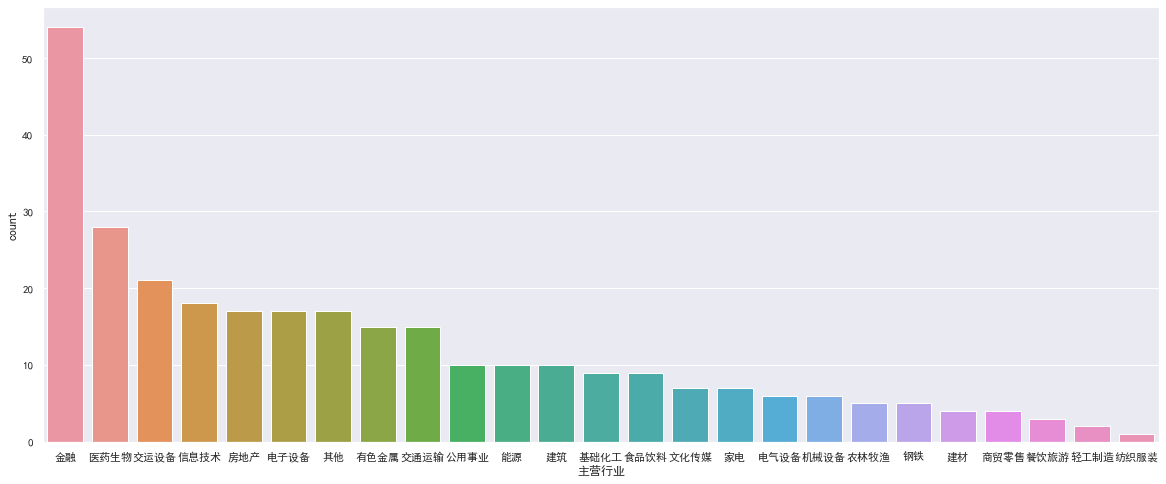

In [10]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
sns.countplot(official_class['主营行业'],ax=ax,order=official_class['主营行业'].value_counts().index)

### Comparable Model: k-means

In [11]:
# another comparable model: k-means model
estimator=KMeans(n_clusters=25)
estimator.fit(cov_matrix)
label_pred=estimator.labels_
centroids=estimator.cluster_centers_
inertia=estimator.inertia_

In [12]:
kmean_class=pd.DataFrame(zip([i[0] for i in comp_corr],label_pred),columns=['company','kmean_class'])
kmean_class.head()

,company,kmean_class
0,000001.SZ,4
1,000002.SZ,14
2,000063.SZ,5
3,000069.SZ,14
4,000100.SZ,5


### Identify classifacation effect

In [13]:
combine_class=official_class.merge(kmean_class,on=['company'],how='right')
combine_class=combine_class.merge(paper_class,on=['company'])

In [14]:
pca=PCA(n_components=2)
truncatedsvd=TruncatedSVD(n_components=2)
reduced_cov_pca=pd.DataFrame(pca.fit_transform(cov_matrix),columns=['pca1','pca2'])
reduced_cov_svd=pd.DataFrame(truncatedsvd.fit_transform(cov_matrix),columns=['svd1','svd2'])
combine_class_pca=pd.concat([combine_class,reduced_cov_pca],axis=1)
combine_class_svd=pd.concat([combine_class,reduced_cov_svd],axis=1)
combine_class_pca[['class','kmean_class','paper_class']]=combine_class_pca[['class','kmean_class','paper_class']].astype('category')
combine_class_svd[['class','kmean_class','paper_class']]=combine_class_svd[['class','kmean_class','paper_class']].astype('category')

In [15]:
combine_class_pca.head()

,company,主营行业,class,kmean_class,paper_class,pca1,pca2
0,000001.SZ,金融,21,4,-252,-0.270357,0.850367
1,000002.SZ,房地产,12,14,-270,-0.040719,-0.104807
2,000063.SZ,信息技术,2,5,-262,-0.038692,-0.053941
3,000069.SZ,房地产,12,14,-270,-0.111135,-0.171067
4,000100.SZ,家电,9,5,-274,0.194707,-0.184710


Text(0.5, 1.0, 'paper class distribution')

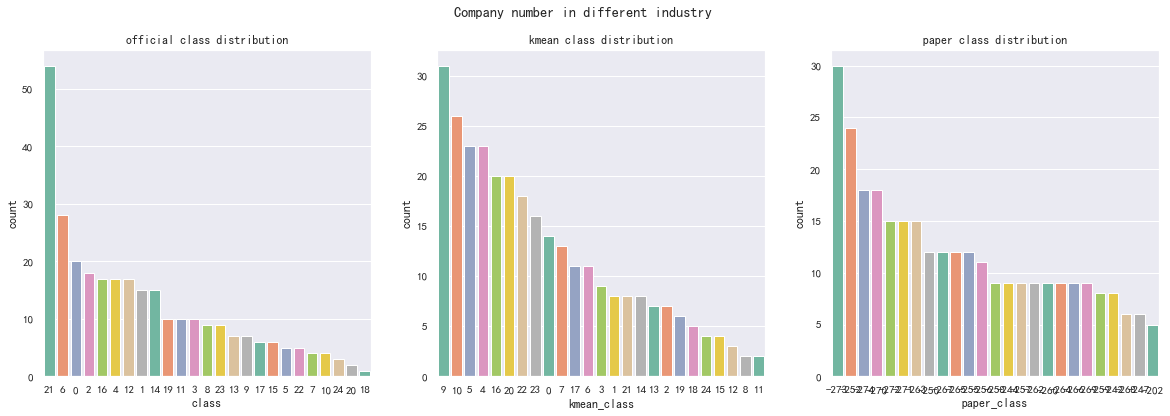

In [40]:
fig, ax= plt.subplots(1,3,figsize=(20,6))
plt.suptitle('Company number in different industry')

sns.countplot(combine_class['class'],ax=ax[0],palette='Set2',order=combine_class['class'].value_counts().index)
ax[0].set_title('official class distribution')
sns.countplot(combine_class['kmean_class'],ax=ax[1],palette='Set2',order=combine_class['kmean_class'].value_counts().index)
ax[1].set_title('kmean class distribution')
sns.countplot(combine_class['paper_class'],ax=ax[2],palette='Set2',order=combine_class['paper_class'].value_counts().index)
ax[2].set_title('paper class distribution')

Text(0.5, 1.0, 'paper class in SVD')

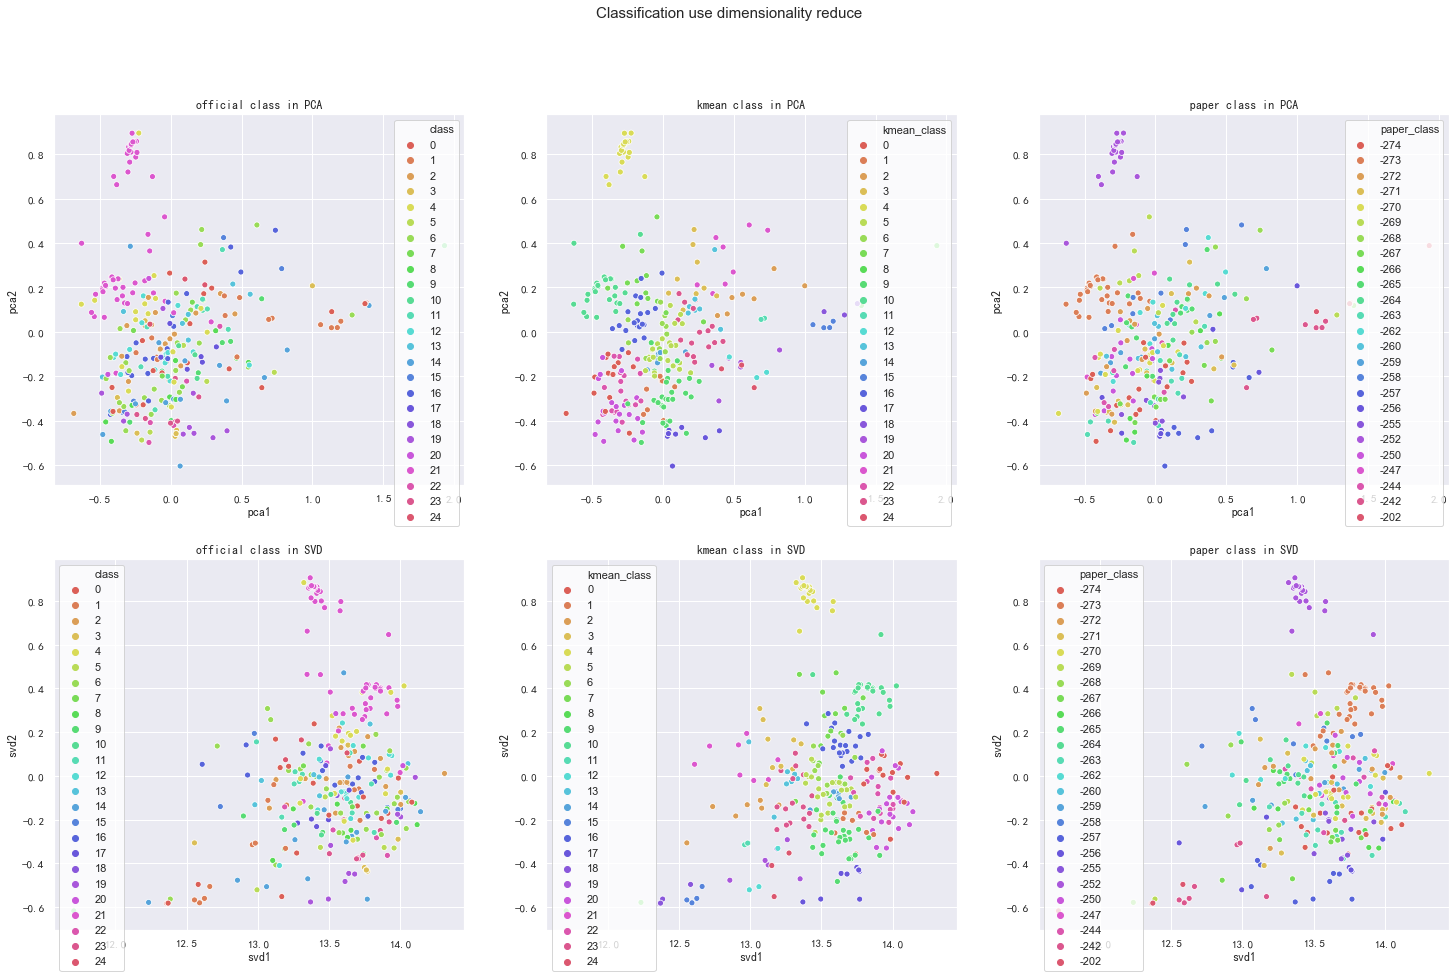

In [41]:
f,ax=plt.subplots(2,3,figsize=(25,15))
sns.set_style("whitegrid")
plt.suptitle('Classification use dimensionality reduce',fontsize=15)

sns.scatterplot(x='pca1',y='pca2',hue='class',data=combine_class_pca,ax=ax[0,0],palette=sns.color_palette("hls", 25))
ax[0,0].set_title('official class in PCA')
sns.scatterplot(x='pca1',y='pca2',hue='kmean_class',data=combine_class_pca,ax=ax[0,1],palette=sns.color_palette("hls", 25))
ax[0,1].set_title('kmean class in PCA')
sns.scatterplot(x='pca1',y='pca2',hue='paper_class',data=combine_class_pca,ax=ax[0,2],palette=sns.color_palette("hls", 25))
ax[0,2].set_title('paper class in PCA')
sns.scatterplot(x='svd1',y='svd2',hue='class',data=combine_class_svd,ax=ax[1,0],palette=sns.color_palette("hls", 25))
ax[1,0].set_title('official class in SVD')
sns.scatterplot(x='svd1',y='svd2',hue='kmean_class',data=combine_class_svd,ax=ax[1,1],palette=sns.color_palette("hls", 25))
ax[1,1].set_title('kmean class in SVD')
sns.scatterplot(x='svd1',y='svd2',hue='paper_class',data=combine_class_svd,ax=ax[1,2],palette=sns.color_palette("hls", 25))
ax[1,2].set_title('paper class in SVD')

In [56]:
disc=pd.read_csv('biz_item.csv')
disc[(disc['ts_code']=='600390.SH') | (disc['ts_code']=='000627.SZ')]

,Unnamed: 0,ts_code,end_date,bz_item,bz_sales,bz_profit,bz_cost,curr_type
5228,0,600390.SH,20190630,期货风险管理业务,3.977061e+09,NaN,NaN,CNY
5229,1,600390.SH,20190630,信托公司,1.521629e+09,NaN,NaN,CNY
5230,2,600390.SH,20190630,证券公司,5.958137e+08,NaN,NaN,CNY
5231,3,600390.SH,20190630,投资公司,6.977142e+04,NaN,NaN,CNY
5232,4,600390.SH,20190630,融资租赁,2.079020e+09,NaN,NaN,CNY
5233,5,600390.SH,20190630,分部间抵销,-2.784156e+05,NaN,NaN,CNY
5234,6,600390.SH,20190630,其他主营业务,1.024423e+06,NaN,NaN,CNY
5235,7,600390.SH,20181231,证券公司,6.031744e+08,-2.107273e+08,8.139018e+08,CNY
5236,8,600390.SH,20181231,期货经纪业务及资产管理业务,5.268221e+08,1.716826e+08,3.551395e+08,CNY
5237,9,600390.SH,20181231,信托公司,2.409705e+09,1.637718e+09,7.719867e+08,CNY


In [57]:
combine_class[combine_class['kmean_class']==5]

,company,主营行业,class,kmean_class,paper_class
2,000063.SZ,信息技术,2,5,-262
4,000100.SZ,家电,9,5,-274
13,000538.SZ,医药生物,6,5,-244
44,002010.SZ,基础化工,8,5,-263
51,002120.SZ,交通运输,1,5,-259
57,002230.SZ,信息技术,2,5,-247
58,002236.SZ,信息技术,2,5,-274
67,002411.SZ,医药生物,6,5,-244
68,002415.SZ,信息技术,2,5,-271
81,002602.SZ,交运设备,0,5,-264


### Test individual return with class return

In [143]:
import tushare as ts
ts.set_token('1dad4f86f90aa240de1a30832a5e1ff4e13c646685852f4f7ac30832')
pro=ts.pro_api()

In [18]:
## validation time 2019/06/30-2019/12/31
return_data=pd.read_csv('stock return 20190630-20191231.csv')[['ts_code','trade_date','pct_chg']]
return_data['trade_date']=pd.to_datetime(return_data['trade_date'],format='%Y%m%d')
return_data.rename(columns={'ts_code':'company','trade_date':'date','pct_chg':'return'},inplace=True)
return_data=return_data.merge(combine_class,on=['company'])
return_data.drop(columns=['主营行业'],inplace=True)
print('return data looks like this: ')
return_data.head()

return data looks like this: 


,company,date,return,class,kmean_class,paper_class
0,000001.SZ,2019-08-20,0.4692,21,4,-252
1,000001.SZ,2019-08-19,0.1342,21,4,-252
2,000001.SZ,2019-08-16,-0.2677,21,4,-252
3,000001.SZ,2019-08-15,-0.2004,21,4,-252
4,000001.SZ,2019-08-14,0.5373,21,4,-252


In [19]:
## company2ind = {company name: class index }
## class_return_map = {class index : pd.DataFrame which contain company return in this class}

company=[i for i in combine_class['company']]
company2ind_paper=dict(zip(combine_class['company'],combine_class['paper_class']))
company2ind_kmean=dict(zip(combine_class['company'],combine_class['kmean_class']))
company2ind_official=dict(zip(combine_class['company'],combine_class['class']))

paper_class_mean=return_data.groupby(by=['paper_class','date']).mean()['return']
kmean_class_mean=return_data.groupby(by=['kmean_class','date']).mean()['return']
official_class_mean=return_data.groupby(by=['class','date']).mean()['return']
                          
paper_class_return_map={i:pd.DataFrame(paper_class_mean[i,]) for i in paper_class_mean.index.levels[0]}
kmean_class_return_map={i:pd.DataFrame(kmean_class_mean[i,]) for i in kmean_class_mean.index.levels[0]}
official_class_return_map={i:pd.DataFrame(official_class_mean[i,]) for i in official_class_mean.index.levels[0]}


In [20]:
for i in company:
    company_class=company2ind_paper[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    paper_class_return_map[company_class]=paper_class_return_map[company_class].join(new_return)

for i in company:
    company_class=company2ind_kmean[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    kmean_class_return_map[company_class]=kmean_class_return_map[company_class].join(new_return)
    
for i in company:
    company_class=company2ind_official[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    official_class_return_map[company_class]=official_class_return_map[company_class].join(new_return)

In [21]:
print('class_return_map looks like this: ')
paper_class_return_map[-257].head()

class_return_map looks like this: 


,return,002294.SZ,600028.SH,600111.SH,600309.SH,600489.SH,601088.SH,601225.SH,601857.SH,601898.SH
date,,,,,,,,,,
2019-07-01,0.720922,2.6363,0.1828,-1.9470,2.5941,-0.8763,0.0981,1.4069,0.7267,1.6667
2019-07-02,-0.016244,0.1306,-0.7299,-0.7943,-0.8656,-0.2947,1.0784,2.0277,-0.2886,-0.4098
2019-07-03,-0.872611,-0.6522,-1.1029,-2.4019,-1.6544,1.2808,0.2425,-2.7197,-0.4342,-0.4115
2019-07-04,-0.452556,-1.1379,1.3011,0.2461,0.1402,-3.5992,-0.6773,-0.4301,0.2907,-0.2066
2019-07-05,0.224733,0.2656,-0.5505,-0.1637,1.4466,1.4127,0.3897,0.2160,-0.5797,-0.4141


In [23]:
print('In official class there is an industry only have one stock: ',le.inverse_transform([18]))

In official class there is an industry only have one stock:  ['纺织服装']


In [24]:
statistical_discribe_paper={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in paper_class_return_map.items()}
statistical_discribe_kmean={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in kmean_class_return_map.items()}
statistical_discribe_official={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in official_class_return_map.items()}

## stats.linregress return [slope, intercept, r_value, p_value, std_err]
## sum of significance is sum of the unsignificant number
## significance level: 99.9%

for i in statistical_discribe_paper:
    reg=[itemgetter(0,2,3)(stats.linregress(paper_class_return_map[i][j][paper_class_return_map[i][j].isna()==False],paper_class_return_map[i]['return'][paper_class_return_map[i][j].isna()==False])) for j in paper_class_return_map[i].columns]
    statistical_discribe_paper[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_paper[i].loc['p']=list(map(lambda x: x[2],reg))
    statistical_discribe_paper[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_paper[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_paper[i]['sum'+str(i)]=statistical_discribe_paper[i].mean(axis=1)
    statistical_discribe_paper[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_paper[i].loc['significance',]==False)
    statistical_discribe_paper[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_kmean:
    reg=[itemgetter(0,2,3)(stats.linregress(kmean_class_return_map[i][j][kmean_class_return_map[i][j].isna()==False],kmean_class_return_map[i]['return'][kmean_class_return_map[i][j].isna()==False])) for j in kmean_class_return_map[i].columns]
    statistical_discribe_kmean[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_kmean[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_kmean[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_kmean[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_kmean[i]['sum'+str(i)]=statistical_discribe_kmean[i].mean(axis=1)
    statistical_discribe_kmean[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_kmean[i].loc['significance',]==False)
    statistical_discribe_kmean[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_official:
    reg=[itemgetter(0,2,3)(stats.linregress(official_class_return_map[i][j][official_class_return_map[i][j].isna()==False],official_class_return_map[i]['return'][official_class_return_map[i][j].isna()==False])) for j in official_class_return_map[i].columns]
    statistical_discribe_official[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))    
    statistical_discribe_official[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_official[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_official[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_official[i]['sum'+str(i)]=statistical_discribe_official[i].mean(axis=1)
    statistical_discribe_official[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_official[i].loc['significance',]==False)
    statistical_discribe_official[i].drop(columns='return',inplace=True)

In [25]:
statistical_discribe_official[0]

,000338.SZ,000625.SZ,000768.SZ,002594.SZ,002602.SZ,002607.SZ,600038.SH,600066.SH,600104.SH,600118.SH,600297.SH,600372.SH,600660.SH,600741.SH,600760.SH,600893.SH,601238.SH,601633.SH,601766.SH,601989.SH,sum0
abs_slope,0.320165,0.256743,0.396466,0.397061,0.14304,0.163878,0.439903,0.324199,0.499016,0.582801,0.427912,0.483221,0.470736,0.32171,0.379769,0.455267,0.334346,0.292655,0.701482,0.36734,0.417034
p,1.74391e-13,1.31117e-14,3.67248e-18,1.31035e-14,0.000726909,0.000156026,1.22493e-15,2.25726e-11,2.65515e-15,1.2338e-27,1.57768e-18,1.87666e-20,1.5502e-12,8.50254e-16,1.2709e-18,4.35646e-15,1.9125e-12,3.83416e-14,7.36475e-17,8.34834e-17,0.000042
significance,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.000000
R2,0.355575,0.381581,0.45726,0.381588,0.0883135,0.109318,0.404511,0.303836,0.397121,0.617342,0.46454,0.501182,0.332802,0.407969,0.466388,0.418426,0.330573,0.370923,0.430633,0.429493,0.411875


In [26]:
wellness={'paper':statistical_discribe_paper,'kmean':statistical_discribe_kmean,'official':statistical_discribe_official}
wellness_summary={'paper':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'kmean':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'official':pd.DataFrame(index=['abs_slope','p','significance','R2'])}

for method in wellness_summary:
    for value in wellness[method].values():
        wellness_summary[method]=wellness_summary[method].join(value.iloc[:,-1])
    wellness_summary[method]['mean']=wellness_summary[method].mean(axis=1)
    wellness_summary[method].loc['significance','mean']=sum(wellness_summary[method].iloc[2,:-1])

wellness_summary['official'].drop(columns='sum18',inplace=True)
wellness_summary['official']['mean']=wellness_summary['official'].iloc[:,:-1].mean(axis=1)
wellness_summary['official'].loc['significance','mean']=sum(wellness_summary['official'].iloc[2,:-1])

In [27]:
wellness_summary['official']

,sum0,sum1,sum2,sum3,sum4,sum5,sum6,sum7,sum8,sum9,sum10,sum11,sum12,sum13,sum14,sum15,sum16,sum17,sum19,sum20,sum21,sum22,sum23,sum24,mean
abs_slope,0.417034,4.613106e-01,5.874313e-01,4.630261e-01,0.353845,6.261485e-01,0.317592,5.523112e-01,4.750626e-01,5.393425e-01,6.531577e-01,6.792459e-01,0.506385,5.666287e-01,4.813878e-01,0.514009,4.574219e-01,5.802093e-01,5.784991e-01,7.627041e-01,6.287697e-01,7.315832e-01,5.546049e-01,5.553192e-01,0.543460
p,0.000042,2.434314e-09,9.310707e-13,2.882690e-08,0.000011,1.261056e-09,0.000013,1.960726e-12,1.499018e-12,5.971869e-10,3.779400e-18,2.887382e-15,0.000105,1.731736e-13,1.725428e-08,0.000006,2.232316e-08,3.765136e-15,7.023262e-11,9.906551e-19,7.150989e-11,1.915841e-20,3.195697e-07,2.363666e-11,0.000007
significance,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
R2,0.411875,4.421384e-01,5.728082e-01,4.372039e-01,0.337970,6.304648e-01,0.316609,5.345400e-01,4.673660e-01,5.345364e-01,6.475720e-01,6.704143e-01,0.500961,5.432281e-01,4.461518e-01,0.515353,4.495011e-01,5.447557e-01,4.983162e-01,7.481831e-01,5.640283e-01,7.282768e-01,5.677419e-01,5.574041e-01,0.527808


Mean of R square of official classification is:  0.5278083079229715
Mean of R square of kmeans classification is:  0.5161661819779153
Mean of R square of paper classification is:  0.48136344604801123


Text(0.5, 1.0, 'p value square of paper classification')

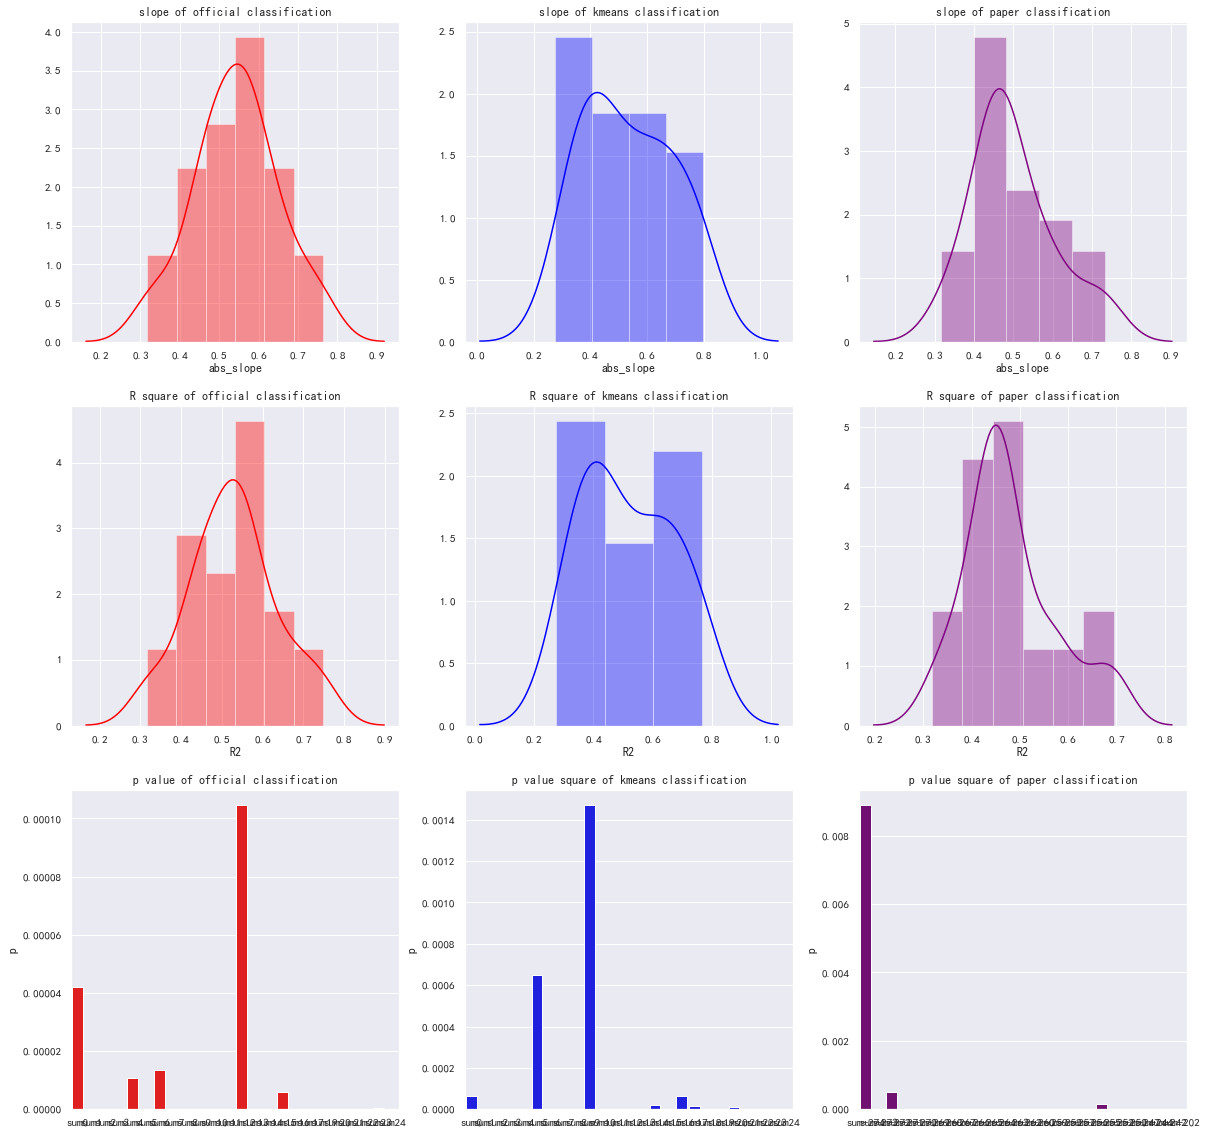

In [28]:
print('Mean of R square of official classification is: ',wellness_summary['official'].loc['R2','mean'])
print('Mean of R square of kmeans classification is: ',wellness_summary['kmean'].loc['R2','mean'])
print('Mean of R square of paper classification is: ',wellness_summary['paper'].loc['R2','mean'])
fig,ax=plt.subplots(3,3,figsize=(20,20))

sns.distplot(wellness_summary['official'].iloc[0,:-1],ax=ax[0,0],color='red')
ax[0,0].set_title('slope of official classification')
sns.distplot(wellness_summary['kmean'].iloc[0,:-1],ax=ax[0,1],color='blue')
ax[0,1].set_title('slope of kmeans classification')
sns.distplot(wellness_summary['paper'].iloc[0,:-1],ax=ax[0,2],color='purple')
ax[0,2].set_title('slope of paper classification')
sns.distplot(wellness_summary['official'].iloc[3,:-1],ax=ax[1,0],color='red')
ax[1,0].set_title('R square of official classification')
sns.distplot(wellness_summary['kmean'].iloc[3,:-1],ax=ax[1,1],color='blue')
ax[1,1].set_title('R square of kmeans classification')
sns.distplot(wellness_summary['paper'].iloc[3,:-1],ax=ax[1,2],color='purple')
ax[1,2].set_title('R square of paper classification')
sns.barplot(x=wellness_summary['official'].columns[:-1],y=wellness_summary['official'].iloc[1,:-1],ax=ax[2,0],color='red')
ax[2,0].set_title('p value of official classification')
sns.barplot(x=wellness_summary['kmean'].columns[:-1],y=wellness_summary['kmean'].iloc[1,:-1],ax=ax[2,1],color='blue')
ax[2,1].set_title('p value square of kmeans classification')
sns.barplot(x=wellness_summary['paper'].columns[:-1],y=wellness_summary['paper'].iloc[1,:-1],ax=ax[2,2],color='purple')
ax[2,2].set_title('p value square of paper classification')

### ANOVA 

In [29]:
total_return=pd.DataFrame(return_data.groupby(by=['company']).apply(lambda df: (1+0.01*df['return']).cumprod().iloc[-1]-1))
total_return=total_return.reset_index().rename(columns={0:'total_return'})
total_return=total_return.merge(combine_class,on='company',how='left')

Text(0.5, 1.0, 'paper class')

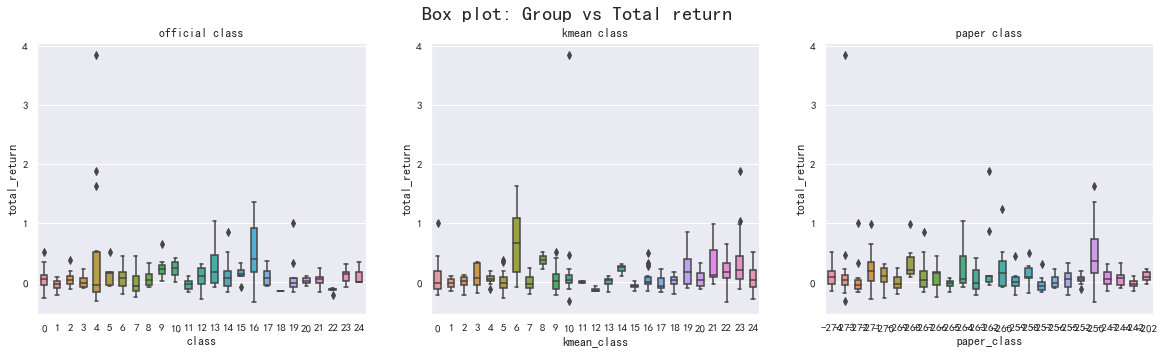

In [38]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
plt.suptitle('Box plot: Group vs Total return',fontsize=20)
sns.boxplot(x='class',y='total_return',data=total_return,ax=ax[0],width=0.5)
ax[0].set_title('official class')
sns.boxplot(x='kmean_class',y='total_return',data=total_return,ax=ax[1],width=0.5)
ax[1].set_title('kmean class')
sns.boxplot(x='paper_class',y='total_return',data=total_return,ax=ax[2],width=0.5)
ax[2].set_title('paper class')

In [34]:
anova_lm(ols('total_return ~ C(主营行业)', data=total_return).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(主营行业),24.0,7.012207,0.292175,2.677312,0.000064
Residual,274.0,29.901649,0.109130,NaN,NaN


In [35]:
anova_lm(ols('total_return ~ C(kmean_class)', data=total_return).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(kmean_class),24.0,7.123424,0.296809,2.729929,0.000045
Residual,274.0,29.790431,0.108724,NaN,NaN


In [36]:
anova_lm(ols('total_return ~ C(paper_class)', data=total_return).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(paper_class),24.0,4.526041,0.188585,1.595424,0.041284
Residual,274.0,32.387815,0.118204,NaN,NaN
